<a href="https://colab.research.google.com/github/tangQAQ/Learning_Recorder/blob/main/Pytorch_moon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

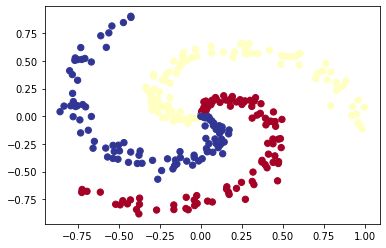

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [ ]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42 )
len(X_train) , len(X_test) , len(y_train), len(y_test)

(240, 60, 240, 60)

In [ ]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task='multiclass', num_classes=4).to(device)
acc_fn
## TODO: uncomment the two lines below to send the accuracy function to the device
# acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
# acc_fn

MulticlassAccuracy()

In [ ]:
# Prepare device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu"
from torch import nn
# Create model by subclassing nn.Module
class combinModel(nn.Module):
  def __init__(self, input, output, hidden):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(input,hidden),
        nn.ReLU(),
        nn.Linear(hidden,hidden),
        nn.ReLU(),
        nn.Linear(hidden,output)
    )
  def forward(self, x):
    return self.linear(x)
# Instantiate model and send it to device
Model_c = combinModel(input=2,
                       output=3,
                       hidden=10).to(device)

Model_c

combinModel(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [ ]:
# Setup data to be device agnostic
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
## Your code here ##

print(Model_c(X_train)[:10])
print("Pred probs:")
## Your code here ##
print(torch.softmax(Model_c(X_train)[:10], dim=1))
print("Pred labels:")
## Your code here ##
print(torch.round(torch.softmax(Model_c(X_train)[:10], dim=1).argmax(dim=1)))

Logits:
tensor([[-0.1012,  0.1222, -0.0859],
        [-0.1106,  0.1203, -0.0939],
        [-0.0655,  0.1406, -0.1010],
        [-0.0075,  0.1770, -0.1335],
        [ 0.0030,  0.1828, -0.1408],
        [-0.0422,  0.1511, -0.1139],
        [-0.0478,  0.1480, -0.1109],
        [-0.1097,  0.1246, -0.0738],
        [-0.0771,  0.1367, -0.1042],
        [-0.0064,  0.1778, -0.1342]], grad_fn=<SliceBackward0>)
Pred probs:
tensor([[0.3062, 0.3829, 0.3109],
        [0.3052, 0.3845, 0.3103],
        [0.3131, 0.3848, 0.3022],
        [0.3242, 0.3899, 0.2858],
        [0.3265, 0.3908, 0.2827],
        [0.3181, 0.3859, 0.2960],
        [0.3169, 0.3855, 0.2976],
        [0.3030, 0.3830, 0.3141],
        [0.3114, 0.3856, 0.3030],
        [0.3244, 0.3901, 0.2855]], grad_fn=<SoftmaxBackward0>)
Pred labels:
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
# Setup loss function and optimizer
# loss_fn =
# optimizer = 

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=Model_c.parameters(),
                            lr=0.01)

In [ ]:
# Build a training loop for the model
epochs = 1000
# Loop over data
for epoch in range(epochs):

  ## Training
  Model_c.train()
  # 1. Forward pass
  y_logits = Model_c(X_train)
  y_prob = torch.softmax(y_logits, dim=1).argmax(dim=1)
  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_prob, y_train)
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  Model_c.eval()
  with torch.inference_mode():
    test_logits = Model_c(X_test)
    test_prob = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # 1. Forward pass
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_prob, y_test)
    # 2. Caculate loss and acc
    if epoch % 100 == 0:
      print(f'epoch: {epoch} | acc:{acc:.2f} | loss:{loss:.2f} | test_acc:{test_acc:.2f} | test_loss:{test_loss:.2f}')
  # Print out what's happening every 100 epochs
  

epoch: 0 | acc:0.35 | loss:1.09 | test_acc:0.27 | test_loss:1.10
epoch: 100 | acc:0.71 | loss:0.51 | test_acc:0.68 | test_loss:0.53
epoch: 200 | acc:0.93 | loss:0.18 | test_acc:0.93 | test_loss:0.16
epoch: 300 | acc:0.98 | loss:0.08 | test_acc:1.00 | test_loss:0.05
epoch: 400 | acc:0.99 | loss:0.05 | test_acc:1.00 | test_loss:0.02
epoch: 500 | acc:0.99 | loss:0.03 | test_acc:1.00 | test_loss:0.01
epoch: 600 | acc:0.99 | loss:0.03 | test_acc:1.00 | test_loss:0.00
epoch: 700 | acc:0.99 | loss:0.03 | test_acc:1.00 | test_loss:0.00
epoch: 800 | acc:0.99 | loss:0.02 | test_acc:1.00 | test_loss:0.00
epoch: 900 | acc:0.99 | loss:0.02 | test_acc:1.00 | test_loss:0.00


In [ ]:
import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

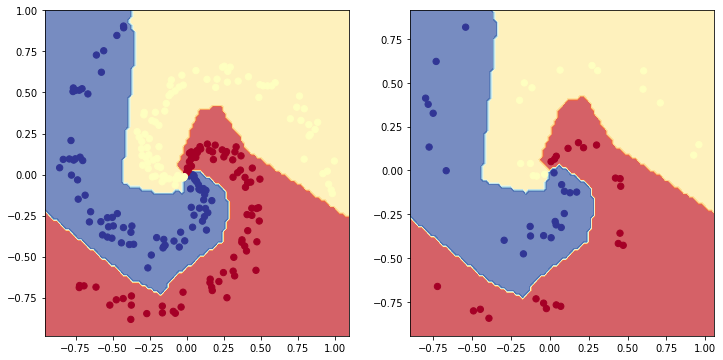

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_decision_boundary(Model_c, X_train, y_train)
plt.subplot(122)
plot_decision_boundary(Model_c, X_test, y_test)